In [19]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [53]:
! unzip 'gdrive/MyDrive/phishIRIS'

Archive:  gdrive/MyDrive/phishIRIS.zip
   creating: phishIRIS/
   creating: phishIRIS/train/
   creating: phishIRIS/.ipynb_checkpoints/
   creating: phishIRIS/val/
   creating: phishIRIS/train/apple/
   creating: phishIRIS/train/chase/
   creating: phishIRIS/train/amazon/
   creating: phishIRIS/train/microsoft/
   creating: phishIRIS/train/other/
   creating: phishIRIS/train/alibaba/
   creating: phishIRIS/train/adobe/
   creating: phishIRIS/train/facebook/
   creating: phishIRIS/train/wellsfargo/
   creating: phishIRIS/train/paypal/
   creating: phishIRIS/train/boa/
   creating: phishIRIS/train/dropbox/
   creating: phishIRIS/train/dhl/
   creating: phishIRIS/train/linkedin/
   creating: phishIRIS/train/yahoo/
   creating: phishIRIS/val/apple/
   creating: phishIRIS/val/chase/
   creating: phishIRIS/val/amazon/
   creating: phishIRIS/val/microsoft/
   creating: phishIRIS/val/other/
   creating: phishIRIS/val/alibaba/
   creating: phishIRIS/val/adobe/
   creating: phishIRIS/val/faceboo

In [54]:
!ls -l

total 5132
drwx------ 5 root root    4096 Jan 21 07:27 gdrive
drwxr-xr-x 5 root root    4096 Dec 19 15:32 phishIRIS
-rw-r--r-- 1 root root 5242880 Jan 21 08:28 phishIRISS.zip
drwxr-xr-x 1 root root    4096 Jan 15 17:28 sample_data


In [67]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

import glob
import os

In [68]:
# re-size all the images to this
height=128
width=128
        

# training config:
epochs = 50
batch_size = 32


In [69]:
list_of_architectures = [
    "Xception",
    "VGG16",
    "VGG19",
    "ResNet50V2",
    "ResNet101V2",
    "ResNet152V2",
    "InceptionV3",
    "MobileNet",
    "MobileNetV2",
    "DenseNet121",
    "DenseNet169",
    "DenseNet201"
    
]

In [70]:
data_dir="phishIRIS/"
train_path = data_dir + 'train'
valid_path = data_dir + 'val'

In [71]:
# useful for getting number of files
image_files = glob.glob(train_path + '/*/*.*')
valid_image_files = glob.glob(valid_path + '/*/*.*')

# useful for getting number of classes
folders = glob.glob(train_path + '/*')

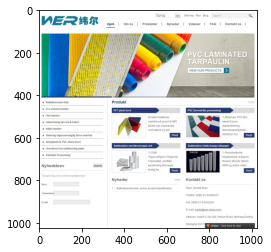

In [72]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [73]:
def createImageAugmentation(preprocess_input, IMAGE_SIZE):
    # create an instance of ImageDataGenerator
    gen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      preprocessing_function=preprocess_input
    )
    
    test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
    print(test_gen.class_indices)
    labels = [None] * len(test_gen.class_indices)
    for k, v in test_gen.class_indices.items():
      labels[v] = k
    
    # create generators
    train_generator = gen.flow_from_directory(
      train_path,
      target_size=IMAGE_SIZE,
      shuffle=True,
      batch_size=batch_size,
    )
    valid_generator = gen.flow_from_directory(
      valid_path,
      target_size=IMAGE_SIZE,
      shuffle=True,
      batch_size=batch_size,
    )
    
    return train_generator, valid_generator, gen, labels

# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


In [74]:
def get_confusion_matrix(data_path, N, gen, model, IMAGE_SIZE):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [75]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)
  figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  #plt.figure(figsize=(10,10))
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [78]:
def classify(model_name):
    
    if model_name == "Xception":
        from keras.applications.xception import Xception, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = Xception(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
    
    elif model_name == "VGG16":
        from keras.applications.vgg16 import VGG16, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = VGG16(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        x = Dense(4096, activation='relu')(x)
        x = Dense(4096, activation='relu')(x)
        
    
    elif model_name == "VGG19":
        from keras.applications.vgg19 import VGG19, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = VGG19(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        x = Dense(4096, activation='relu')(x)
        x = Dense(4096, activation='relu')(x)
        
    elif model_name == "ResNet50V2":
        from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = ResNet50V2(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "ResNet101V2":
        from keras.applications.resnet_v2 import ResNet101V2, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = ResNet101V2(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "ResNet152V2":
        from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = ResNet152V2(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "InceptionV3":
        from keras.applications.inception_v3 import InceptionV3, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = InceptionV3(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)

    elif model_name == "MobileNet":
        from keras.applications.mobilenet import MobileNet, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = MobileNet(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "MobileNetV2":
        from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = MobileNetV2(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "DenseNet121":
        from keras.applications.densenet import DenseNet121, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = DenseNet121(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "DenseNet169":
        from keras.applications.densenet import DenseNet169, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = DenseNet169(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
        
    elif model_name == "DenseNet201":
        from keras.applications.densenet import DenseNet201, preprocess_input
        IMAGE_SIZE = [height, width]
        train_generator, valid_generator, gen, labels = createImageAugmentation(preprocess_input, IMAGE_SIZE)
        base_model = DenseNet201(input_shape=(height, width,3), weights='imagenet', include_top=False)
        for layers in base_model.layers:
            layers.trainable=False
        x = Flatten()(base_model.output)
    
    prediction = Dense(15, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=prediction)
        
    

    print(model.summary())
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    r = model.fit_generator(
      train_generator,
      validation_data=valid_generator,
      epochs=epochs,
      steps_per_epoch=len(image_files) // batch_size,
      validation_steps=len(valid_image_files) // batch_size,
    )

    cm = get_confusion_matrix(train_path, len(image_files), gen, model, IMAGE_SIZE)
    valid_cm = get_confusion_matrix(valid_path, len(valid_image_files), gen, model, IMAGE_SIZE)

    # loss
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(r.history['accuracy'], label='train acc')
    plt.plot(r.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

    #from util import plot_confusion_matrix
    plot_confusion_matrix(cm, labels, title='Train confusion matrix')
    plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

Xception
Found 1539 images belonging to 15 classes.
{'adobe': 0, 'alibaba': 1, 'amazon': 2, 'apple': 3, 'boa': 4, 'chase': 5, 'dhl': 6, 'dropbox': 7, 'facebook': 8, 'linkedin': 9, 'microsoft': 10, 'other': 11, 'paypal': 12, 'wellsfargo': 13, 'yahoo': 14}
Found 1313 images belonging to 15 classes.
Found 1539 images belonging to 15 classes.
83689472/83683744 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
41/41 [==============================] - 195s 5s/step - loss: 2.4723 - accuracy: 0.2615 - precision_2: 0.4477 - recall_2: 0.0955 - val_loss: 1.6101 - val_accuracy: 0.5033 - val_precision_2: 0.8188 - val_recall_2: 0.1706
Epoch 2/50
41/41 [==============================] - 190s 5s/step - loss: 1.8428 - accuracy: 0.4286 - precision_2: 0.6883 - recall_2: 0.1603 - val_loss: 1.2301 - val_accuracy: 0.6706 - val_precision_2: 0.9219 - val_recall_2: 0.3613
Epoch 3/50
41/41 [==============================] - 189s 5s/step - loss: 1.5563 - accuracy: 0.5013 - precision_2: 0.7461 - recall_2: 0.2298 - val_loss: 1.2360 - val_accuracy: 0.6504 - val_precision_2: 0.8695 - val_recall_2: 0.3730
Epoch 4/50
41/41 [==============================] - 189s 5s/step - loss: 1.4294 - accuracy: 0.5576 - precision_2: 0.7873 - recall_2: 0.2991 - val_loss: 1.0804 - val_accuracy: 0.6940 - val_precision_2: 0.8699 - val_recall_2: 0.5007
Epoch 5/50
41/41 [==============================] - 190s 5s/step - loss: 1.3

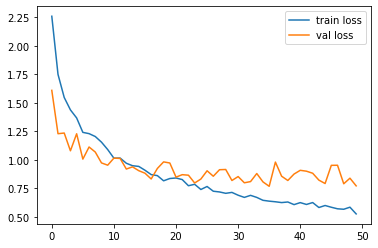

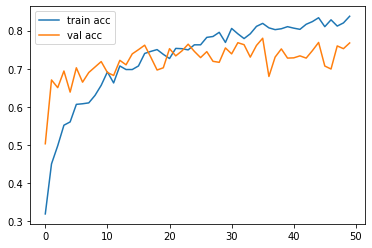

Confusion matrix, without normalization


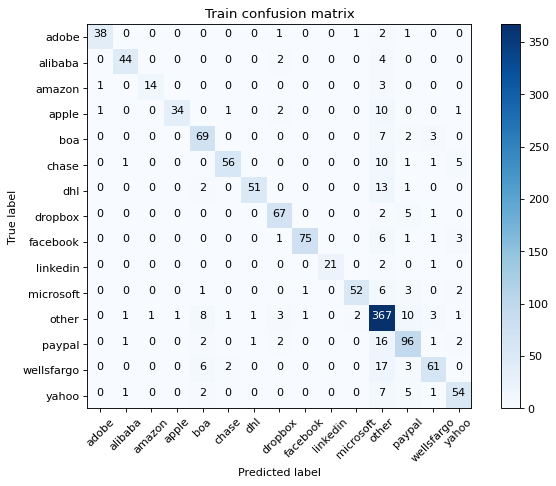

Confusion matrix, without normalization


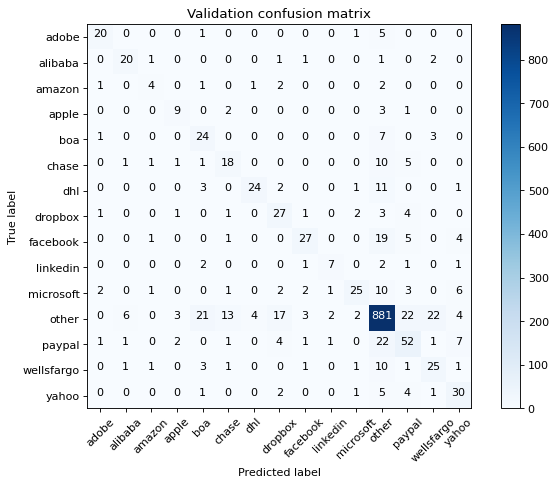

VGG16
Found 1539 images belonging to 15 classes.
{'adobe': 0, 'alibaba': 1, 'amazon': 2, 'apple': 3, 'boa': 4, 'chase': 5, 'dhl': 6, 'dropbox': 7, 'facebook': 8, 'linkedin': 9, 'microsoft': 10, 'other': 11, 'paypal': 12, 'wellsfargo': 13, 'yahoo': 14}
Found 1313 images belonging to 15 classes.
Found 1539 images belonging to 15 classes.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
___________________________________________________

In [ ]:
for model_name in list_of_architectures:
    print(model_name)
    classify(model_name)